### OpenAI gym in Webots
- An OpenAI Gym expects that `env.step(action)` progresses an environment by one unit of time
    - I think this unit of time is determined by a gym environment design
        - the time unit is your choice when you design your own gym environment
- When you call `Supervisor.step(time_step)` inside a supervisor controller, the Webot physics world evolves by `time_step`.
    - You are supposed to call this as soon as other things are done.

In [ ]:
import numpy as np

from controller import Supervisor
import gym


class MyEnvironment(gym.Env, Supervisor):
    def __init__(self):
        super().__init__()
        self.__time_step = 32

        # you might want to get devices and enable them

    def reset(self):
        # Reset the simulation
        self.simulationResetPhysics()
        self.simulationReset()

        # you need to initialize devices here too
        super().step(self.__time_step)

    def step(self, action):
        # apply action to the robot here!
        # change motor torques, speeds, or position
        
        # both of gym.Env and Supervisor have 'step'
        # Since Supervisor follows gym.Env, MRO resolves this step to Supervisor.step
        super().step(self.__time_step)

        # interpret the environment
        # reading sensor values
        # check episode terminating conditions
        state = [0] * 12
        done = False
        reward = 0

        return np.asarray(state), reward, done, {}

    def render(self, mode='human'):
        """
        Do you want to render something else?
        """
        pass

[### Stable Baselines3](https://github.com/DLR-RM/stable-baselines3)
- it provides implementations of popular RL algorithms (many in `stable_baselines3` package)
    - you can choose the policy implementation
        - MlpPolicy (Multi-Layer Perceptrons, 2 layers of 64)
        - CnnPolicy (the nature CNN)
        - and more
- its model (or agent) take a gym environment.
- I think `model.learn` calls `env.step` repeatedly while it learn.

In [ ]:
from stable_baselines3 import DQN

env = MyEnvironment()
model = DQN("MlpPolicy", env)
model.learn(total_timesteps=2500)
model.save('my_learning_model')

del model
model = DQN.load('my_learning_model')


### [Universal Value Function Approximators (UVFA) (2015)](https://proceedings.mlr.press/v37/schaul15.html)
- extension of `DQN` with more than one goal
    - an action-value function in `DQN` is a DNN
- Multi-goal RL
    - More than one goal $g \in \mathcal{G}$ and corresponding reward functions $r_g : \mathcal{S} \times \mathcal{A} \rightarrow \mathbb{R}$.
        - or $r_g(s_t, a_t) = r(s_t, a_t, g)$ in this form
        - should it be $r_{t+1} = r(s_t, a_t, s_{t+1}, g)$ more generally?
    - assume that the agent is to achieve $f_g(s) = 1$ for a given goal $g$.
    - assume that it is easy to find a mapping $m : \mathcal{S} \rightarrow \mathcal{G}$ such that $f_{m(s)}(s) = 1$.
        - you need this for replaying with modified goals $m(s)$
        - for a robotic arm reach environment, it means we have a forward kinematics
            - $s$ are joint angles, $g = m(s)$ is an end-effector pose
- The goal stays fixed for a whole episode
- An agent has access to the current goal too.
    - A policy $\pi : \mathcal{S} \times \mathcal{G} \rightarrow \mathcal{A}$
- $Q$-function (or action-value function?) $Q^{\pi}(s_t, a_t, g) = \mathbb{E}\left[ R_t | s_t, a_t, g \right]$
    - note that $R_t = r_{t+1} + \gamma r_{t+2} + \gamma^2 r_{t+3} + \cdots$.

<br />

### [Hindsight Experience Replay (HER) (2018)](https://arxiv.org/pdf/1707.01495.pdf)
- works with an off-policy RL algorithm
- replays episodes with a modified goal (, which is different from the original goal)
- replay strategies $G = \mathbb{S}(\text{current episode})$ (choice for the modified goals)
    - `final` the final state of that episode for any $s_t$ in that episode
        - $\mathbb{S}(s_1, \cdots, s_T) = m(s_T)$
    - `future` $k$ random states from the same episode which comes after that transition?
        - random $k$ samples from $\left\{ s_{t+1}, \cdots, s_T \right\}$?
    - `episode` $k$ random states from the same episode
        - random $k$ samples from $\left\{ s_1, \cdots, s_T \right\}$?
    - `random` $k$ random states encountered so far in the whole training procedure
        - I guess the number of encountered states would be enormous. How can track all these states?
- initial states shoud be random? is it critical to initialize the initial state random?

<br />

### OpenAI goal-based gym
- ‘FetchReach-v0’ environment requires `mujoco-py` and MuJoCo
- `mujoco-py` requires cuda sdk?
- it may require `sudo apt-get install libosmesa6-dev` and `sudo apt-get install patchelf`


#### exploration
- in the action space
    - $\mathbf{a}_t = \mu(s_t; \theta_{\mu}) + \epsilon_t$, where $\mu(s_t;\theta_{\mu}) $ is a controller output and $\epsilon_t \sim \mathcal{N}(0, \sigma^2) $
- in the parameter space
    - $\mathbf{a}_t = \mu(s_t; \theta_{\mu} + \epsilon)$, where $\epsilon \sim \mathcal{N}(0, \sigma^2)$.
- state dependent exloration (**SDE**)
    - $\mathbf{a}_t = \mu(s_t; \theta_{\mu}) + \epsilon(s_t, \theta_{\epsilon})$, where $\theta_{\epsilon} \sim \mathcal{N}(0, \sigma^2)$
    - $\theta_{\epsilon}$ remains the same for an episode.

#### stable-baselines3
- some requires `tensorflow==1.14` but it seems like python3.8 does not work with `tensorflow==1.14`
- stable-baselines3 works with `python3.7+`
    - it's convenient to use conda env since I can choose the python version
- `conda create --name tensorflow-14 \
    tensorflow-gpu=1.14 \
    python=3.7`

#### animation using `ipywidgets.Image`
- `xvfb-run jupyter notebook`
    - in order to suppress the pygame window of openai gym
- the image is updated when `img_widget.value` is updated

In [ ]:
import io
import numpy as np

import gym
import highway_env

import PIL
from IPython.display import Image, display, clear_output, update_display
import ipywidgets as widgets


def png_from_array(img):
    """
    png encoding from numpy array
    """
    pil_img = PIL.Image.fromarray(img)

    buffer = io.BytesIO()
    pil_img.save(buffer, format='png')
    
    return bytes(buffer.getbuffer())


env = gym.make('parking-v0')
env.reset()

img = env.render(mode='rgb_array')
img_widget = widgets.Image(value=png_from_array(img), format='png', width=400)
display(img_widget)

for i in range(60 * 3):
    env.step(np.random.rand(2) * 2 - 1)
    img = env.render(mode='rgb_array')
    img_widget.value = png_from_array(img)
    

#### DDPG works on 'Parking-v0'?

In [ ]:
import gym
import numpy as np

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

env = gym.make("parking-v0")

# The noise objects for DDPG
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# what kind of Q and mu networks (and their targets) are employed?
# "MultiInputPolicy" indicates topologies too?
model = DDPG("MultiInputPolicy", env, action_noise=action_noise, verbose=1)


In [ ]:
model.learn(total_timesteps=10000, log_interval=10)
# model.save("ddpg_pendulum")
# env = model.get_env()

# del model # remove to demonstrate saving and loading

# model = DDPG.load("ddpg_pendulum")

In [ ]:
from stable_baselines3 import HerReplayBuffer, DDPG, DQN, SAC, TD3
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.noise import NormalActionNoise

env = gym.make("parking-v0")

n_actions = env.action_space.shape[0]
noise_std = 0.2
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=noise_std * np.ones(n_actions))

n_sampled_goal = 4

# Available strategies (cf paper): future, final, episode
goal_selection_strategy = 'future' # equivalent to GoalSelectionStrategy.FUTURE

# If True the HER transitions will get sampled online
online_sampling = True

# Time limit for the episodes
max_episode_length = 100

# SAC hyperparams:
model = HER('MlpPolicy', env, SAC, n_sampled_goal=n_sampled_goal,
            replay_buffer_class=HerReplayBuffer,
            replay_buffer_kwargs=dict(n_sampled_goal=4,
                                      goal_selection_strategy=goal_selection_strategy,
                                      online_sampling=online_sampling,
                                      max_episode_length=max_episode_length),
           verbose=1)


model.learn(int(100))

In [4]:
obs = env.reset()

img = env.render(mode='rgb_array')
img_widget = widgets.Image(value=png_from_array(img), format='png', width=400)
display(img_widget)

for _ in range(100):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)
#     env.render()
    img = env.render(mode='rgb_array')
    img_widget.value = png_from_array(img)

    if dones:
        break

NameError: name 'png_from_array' is not defined

#### exploration
- in the action space
    - $\mathbf{a}_t = \mu(s_t; \theta_{\mu}) + \epsilon_t$, where $\mu(s_t;\theta_{\mu}) $ is a controller output and $\epsilon_t \sim \mathcal{N}(0, \sigma^2) $
- in the parameter space
    - $\mathbf{a}_t = \mu(s_t; \theta_{\mu} + \epsilon)$, where $\epsilon \sim \mathcal{N}(0, \sigma^2)$.
- state dependent exloration (**SDE**)
    - $\mathbf{a}_t = \mu(s_t; \theta_{\mu}) + \epsilon(s_t, \theta_{\epsilon})$, where $\theta_{\epsilon} \sim \mathcal{N}(0, \sigma^2)$
    - $\theta_{\epsilon}$ remains the same for an episode.

#### stable-baselines3
- some modules require `tensorflow==1.14` but it seems like `tensorflow==1.14` pypi package does not support the latest pip for python3.8
- stable-baselines3 works with `python3.7+`
    - it's convenient to use conda env since I can choose the python version
- `conda create --name tensorflow-14 \
    tensorflow-gpu=1.14 \
    python=3.7`

#### animation using `ipywidgets.Image`
- `xvfb-run jupyter notebook`
    - in order to suppress the pygame window of openai gym
- the image is updated when `img_widget.value` is updated

In [15]:
import io
import numpy as np

import gym
import highway_env

import PIL
from IPython.display import Image, display, clear_output, update_display
import ipywidgets as widgets


def png_from_array(img):
    """
    png encoding from numpy array
    """
    pil_img = PIL.Image.fromarray(img)

    buffer = io.BytesIO()
    pil_img.save(buffer, format='png')
    
    return bytes(buffer.getbuffer())


env = gym.make('parking-v0')
env.reset()

img = env.render(mode='rgb_array')
img_widget = widgets.Image(value=png_from_array(img), format='png', width=400)
display(img_widget)

for i in range(60 * 3):
    env.step(np.random.rand(2) * 2 - 1)
    img = env.render(mode='rgb_array')
    img_widget.value = png_from_array(img)
    

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x01,\x08\x02\x00\x00\x00\x90_Z\xc1\x00\…

In [16]:
import gym
import numpy as np

from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

env = gym.make("parking-v0")

# The noise objects for DDPG
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# what kind of Q and mu networks (and their targets) are employed?
# "MultiInputPolicy" indicates topologies too?
model = DDPG("MultiInputPolicy", env, action_noise=action_noise, verbose=1)


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [17]:
model.learn(total_timesteps=10000, log_interval=10)
# model.save(\"ddpg_pendulum\")
# env = model.get_env()

# del model # remove to demonstrate saving and loading

# model = DDPG.load("ddpg_pendulum")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -72      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 10       |
|    fps             | 74       |
|    time_elapsed    | 13       |
|    total_timesteps | 1000     |
| train/             |          |
|    actor_loss      | 2.93     |
|    critic_loss     | 0.109    |
|    learning_rate   | 0.001    |
|    n_updates       | 800      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 100      |
|    ep_rew_mean     | -67      |
|    success_rate    | 0        |
| time/              |          |
|    episodes        | 20       |
|    fps             | 72       |
|    time_elapsed    | 27       |
|    total_timesteps | 2000     |
| train/             |          |
|    actor_loss      | 3.45     |
|    critic_loss     | 0.121    |
|    learning_

In [23]:
from stable_baselines3 import HerReplayBuffer, DDPG, DQN, SAC, TD3
from stable_baselines3.her.goal_selection_strategy import GoalSelectionStrategy
from stable_baselines3.common.noise import NormalActionNoise

env = gym.make("parking-v0")

n_actions = env.action_space.shape[0]
noise_std = 0.2
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=noise_std * np.ones(n_actions))

n_sampled_goal = 4

# Available strategies (cf paper): future, final, episode
goal_selection_strategy = 'future' # equivalent to GoalSelectionStrategy.FUTURE

# If True the HER transitions will get sampled online
online_sampling = True

# Time limit for the episodes
max_episode_length = 100

# SAC hyperparams:
model = DDPG("MultiInputPolicy",
            env,
            replay_buffer_class=HerReplayBuffer,
            replay_buffer_kwargs=dict(
                n_sampled_goal=4,
                goal_selection_strategy=goal_selection_strategy,
                online_sampling=online_sampling,
                max_episode_length=max_episode_length),
           verbose=1)


model.learn(int(100))

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [24]:
obs = env.reset()

img = env.render(mode='rgb_array')
img_widget = widgets.Image(value=png_from_array(img), format='png', width=400)
display(img_widget)

for _ in range(100):
    action, _states = model.predict(obs)
    obs, rewards, dones, info = env.step(action)

    img = env.render(mode='rgb_array')
    img_widget.value = png_from_array(img)

    if dones:
        break

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x01,\x08\x02\x00\x00\x00\x90_Z\xc1\x00\…

### MountainCar-v0
- discrete action `Discrete(3)`
- observatin space is `Box([-1.2, -0.07], [0.6, 0.07], (2,), float32)`
    - (left bottom) and (right top)
- VPG, A2C, DQN can be employed
- state-space representation like
    - $ \left[ \begin{matrix} x_{k+1} \\ v_{k+1} \end{matrix} \right] = \left[ \begin{matrix} 1 & \Delta \\ 0 & 1 \end{matrix} \right] \left[ \begin{matrix} x_k \\ v_k \end{matrix} \right] + \left[ \begin{matrix} \Delta / 2 \\ 1 \end{matrix} \right] u $
    - 

<br/>

#### DQN on MountainCar-v0
- off-policy learning
    - replay buffer
- $\epsilon$-greedy policy is good?

In [222]:
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


class MyDQN(nn.Module):
    """
    off-policy learning
    
    replay buffer
    epsilon-greedy policy
    
    max episode length = 100
    one batch training for a new episode?
    
    minimize TD-error
    """
    def __init__(self):
        super().__init__()
        
        self.l1 = nn.Linear(2, 128)
        self.l2 = nn.Linear(128, 128)
        self.l3 = nn.Linear(128, 3)
        
        self.do = nn.Dropout(0.5)
        self.loss_fn = nn.MSELoss()
        self.optimizer = optim.Adam(self.parameters())
        
        # (s, a, r, s', done)
        self.replay_buffer = []
        self.states = []
    
    def forward(self, x):
        x = self.do(F.relu(self.l1(x)))
        x = self.do(F.relu(self.l2(x)))
        x = F.relu(self.l3(x))
        
        return x
    
    def action(self, states):
        """
        epsilon-greedy policy
        """
        if np.random.rand() < 0.1:
            return np.random.choice(3)
        
        _, action = torch.max(self(torch.unsqueeze(states, dim=0)), axis=-1)
        return action.item()

    @torch.no_grad()
    def rollout(self, widget=None):
        self.eval()
        s = env.reset()
        
#         if self.states:
#         init_state = env.observation_space.sample()
#             idx = np.argmin([np.linalg.norm(state - random_sample) for state in self.states])
#             env.unwrapped.state = self.states[idx]
#         env.unwrapped.state = init_state
        
        done = False
        while not done:
            a = self.action(torch.Tensor(s).unsqueeze(dim=0))
            sp, r, done, info = env.step(a)
            self.replay_buffer.append((s, a, r, sp, done))
            self.states.append(sp)
            
            if widget:
                img = env.render(mode='rgb_array')
                pil_img = PIL.Image.fromarray(img)
                buffer = io.BytesIO()
                pil_img.save(buffer, 'png')
                widget.value = bytes(buffer.getbuffer())
        
        if not info:
            print('success')
            raise ValueError(f'sucess r={r}, sp={sp}, info={info}')
        
        random.shuffle(self.replay_buffer)
        self.replay_buffer = self.replay_buffer[:10000]
        
        random.shuffle(self.states)
        self.states = self.states[:10000]

    def train_epoch(self):
        self.train()
        
        for x in range(len(self.replay_buffer) // 32):
            batch = self.replay_buffer[32 * x:32 * (x + 1)]

            # ||Q_w(s, a) - r + gamma * (1 - done) * max_a' Q_w(s', a')||^2
            s, a, r, sp, done = zip(*batch)
            s = torch.Tensor(s).detach()
            r = torch.Tensor(r)
            sp = torch.Tensor(sp)
            done = torch.Tensor(done)

            # old action values
            q = self(s)

            # one-step look ahead
            ne = r + torch.where(done > 0.5,
                                 0.99 * torch.max(self(sp), axis=-1)[0], 
                                 torch.zeros(len(batch)))
            
            # what does exactly clone do?
            target = q.clone()
            target[range(32), a] = ne

            # q -> target
            loss = self.loss_fn(q, target.detach())
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()


In [210]:
import io

import gym
import PIL
import ipywidgets.widgets as widgets

# action_space
# 0 -> no acceleration, 1 -> accelerate to the left, 2 -> accelerate to the right
# observation_space
# 
env = gym.make('MountainCar-v0')
env.reset()

img = env.render(mode='rgb_array')
pil_img = PIL.Image.fromarray(img)
buffer = io.BytesIO()
pil_img.save(buffer, 'png')

mountain_car_widget = widgets.Image(
    value=bytes(buffer.getbuffer()),
    format='png',
    width=300
)

mountain_car_widget

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02X\x00\x00\x01\x90\x08\x02\x00\x00\x00\xfdW\x89\xc…

In [223]:
dqn = MyDQN()

In [225]:
for i in range(100):
    dqn.rollout(widget=mountain_car_widget)
#     dqn.train_epoch()


Text(0, 0.5, 'velocity')

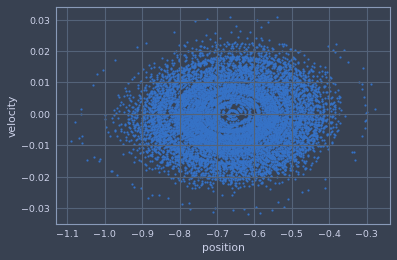

In [226]:
import numpy.linalg
import matplotlib.pyplot as plt


fig, ax = plt.subplots()

ax.scatter([x[0] for x in dqn.states],
           [x[1] for x in dqn.states], s=4)

ax.set_xlabel('position')
ax.set_ylabel('velocity')
# random_sample = np.asarray([0.4, 0.5])

# idx = np.argmin([np.linalg.norm(state - random_sample) for state in dqn.states])
# print(dqn.states[idx])

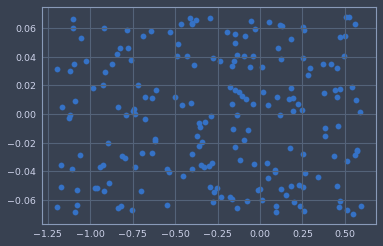

In [39]:
import matplotlib.pyplot as plt


states = [env.observation_space.sample() for _ in range(200)]

fig, ax = plt.subplots()
ax.scatter([x[0] for x in states],
           [x[1] for x in states])

#### value iterations
- Even though the state space of the MountainCar-v0 is continuous, the value iteration technique might work using a neural net action value function.
- one nice thing is that a state space is randomly sampled.
- 